### <center>COMPUTATIONAL METHODS IN FINANCE - MGMTMFE 405</center>
### <center>Project - 3</center>
#### <center>Akhil Srivastava</center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import ncx2
from scipy import integrate
from scipy import optimize

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Note - In many cases, though not asked Analytical Solutions have been added for validation purpose.

## Question 1

In [2]:
# Simulates jump times using exponential distribution
def sim_jump_times(𝜆1=0.2, 𝑇=5):
    # List to store jump-times
    jump_times = []

    # While the sum of the jump-times is less than T keep generating additional jumps
    while sum(jump_times) < T:
        jump_times.append(expon.rvs(scale=1/𝜆1))

    # Drop the last jump time as it is above T and return jump_times
    return jump_times[:-1]

# Computes qt value
def q(𝛼, 𝛽, t):
    return 𝛼 + 𝛽*t

# Computes Lt value
def L(a, b, c, t):
    return a - b*c**(12*t)

In [3]:
# Estimates the value of a default option, default probability and it's expected exercise time
# Uses Monte Carlo simulation with Euler’s discretization for the collateral value following a jump-diffusion process
# Simulates jump times using exponential distribution

def Proj3_2func(𝜆1=0.2, 𝑇=5, 𝑉0=20000, 𝜇=-0.1, 𝜎=0.2, 𝛾=-0.4,
                L0=22000, 𝑟0=0.055, 𝛿=0.25, 𝜆2=0.4, 𝛼=0.7, 𝜖=0.95,
                M=10000, n=10, seed=42):
    # Seed random number generator
    np.random.seed(seed)
    
    # Compute value of all the path independent variables    
    R = r0 + 𝛿*𝜆2
    r = R/12
    n_periods = 12*T
    PMT = (L0*r)/(1-1/(1+r)**n_periods)
    
    a = PMT/r
    b = PMT/(r*(1+r)**n_periods)
    c = 1+r
    𝛽 = (𝜖 - 𝛼)/T
    
    # Create an array to store Default Option Value for each path
    DOV = np.zeros(M)
    
    # Create an array to store option Exercise Time for each path
    Ex_Time = np.array([np.inf]*M)

    # Simulate M paths for the value of the collateral V and compute DOV along each path
    for i in range(M):
        # Compute uniform time partition size
        Δ = T/n

        # Compute uniform time partition values
        unif_times = [k*Δ for k in range(n+1)]

        # Simulate jump times
        jump_times = sim_jump_times(𝜆1, 𝑇)
        
        # Merge and sort the two sets of time values
        all_times = sorted(unif_times + jump_times)

        # Initialize collateral value with value at time t=0
        Vt = V0

        # Create a stanrard normal sample for each time value
        z = np.random.normal(0, 1, len(all_times))
        
        # Iterate over all the time step values, compute Vt, qt, Lt and if required payoff and option value
        for k in range(1, len(all_times)):
            # Compute time delta (step_Δ) for this time-step
            # Note - There could be more than one jumps within a uniform time-step
            # Case 1 : Current time is a jump-time
            #   step_Δ = time of this jump - last uniform/jump time value
            # Case 2 : Current time is a uniform time partition boundary
            #   a. step_Δ = Δ if the previous time value was also a uniform time partition boundary, otherwise
            #   b. step_Δ = time of this jump - last uniform/jump time value
            step_Δ = all_times[k] - all_times[k-1]

            # Apply usual Euler's discretization scheme irrespective of uniform or jump time value
            # As step_Δ already handles the change in the time step value
            Vt = Vt + Vt*𝜇*step_Δ + Vt*𝜎*step_Δ**0.5*z[k]

            # If this is a jump time, apply the jump using additional 𝛾 effect
            if all_times[k] in jump_times:
                Vt = Vt*(1 + 𝛾)

            # Compute qt and Lt values
            qt = q(𝛼, 𝛽, all_times[k])
            Lt = L(a, b, c, all_times[k])

            # If collateral value is lte qt*Lt this is “optimal exercise boundary”, because
            #  a. All the values in all_times are lte T and
            #  b. This is the first time threshold condition is met as we move to the next path after handling a breach
            # Compute payoff and option value and move to the next path
            if Vt <= qt*Lt:
                # Compute payoff and option value
                payoff = max(0, Lt - 𝜖*Vt)
                DOV[i] = np.exp(-r0*all_times[k])*payoff

                # Store excercise time
                Ex_Time[i] = all_times[k]

                # Move to the next path
                break
        
    # Filter paths where exercise time is less than T
    Ex_Time = Ex_Time[Ex_Time < T]
    
    # Return mean of all the simulated option values
    return DOV.mean(), len(Ex_Time)/M, Ex_Time.mean()

In [4]:
# Base-case parameter values

𝑉0 = 20000
L0 = 22000

𝜇 = -0.1
𝜎 = 0.2
𝛾 = -0.4

𝜆1 = 0.2
𝑇 = 5

𝑟0 = 0.055
𝛿 = 0.25
𝜆2 = 0.4
𝛼 = 0.7
𝜖 = 0.95

# Number of simulations
M = 10000

# Number of uniform time steps
n = 100

# Seed for random number generator
seed = 42

**𝜆1 = 0.2 and T = 5**

In [5]:
dov, def_prob, avg_ex_time = Proj3_2func(𝜆1, 𝑇, 𝑉0, 𝜇, 𝜎, 𝛾, L0, 𝑟0, 𝛿, 𝜆2, 𝛼, 𝜖, M, n, seed)

In [6]:
print("The value of the default option = {:.4f}".format(dov))
print("The default probability = {:.4f}".format(def_prob))
print("The expected option exercise time = {:.4f}".format(avg_ex_time))

The value of the default option = 4727.7260
The default probability = 0.6852
The expected option exercise time = 0.9902


**𝜆1 = [0.05, 0.4] and T = [3, 8]**

In [7]:
# Define the grid
T_vals = range(3, 9, 1)
𝜆1_vals = [i/100 for i in range(5, 45, 5)]

# Create dataframe to store values
df_q1_dov = pd.DataFrame()
df_q1_def_prob = pd.DataFrame()
df_q1_avg_ex_time = pd.DataFrame()

df_q1_dov["T"] = T_vals
df_q1_def_prob["T"] = T_vals
df_q1_avg_ex_time["T"] = T_vals

In [8]:
# Compute values
for i in range(len(𝜆1_vals)):
    for j in range(len(T_vals)):
        dov, def_prob, avg_ex_time = Proj3_2func(𝜆1_vals[i], T_vals[j], 𝑉0, 𝜇, 𝜎, 𝛾, L0, 𝑟0, 𝛿, 𝜆2, 𝛼, 𝜖, M, n, seed)
        df_q1_dov.loc[j, "𝜆1="+ str(𝜆1_vals[i])] = dov
        df_q1_def_prob.loc[j, "𝜆1="+ str(𝜆1_vals[i])] = def_prob
        df_q1_avg_ex_time.loc[j, "𝜆1="+ str(𝜆1_vals[i])] = avg_ex_time

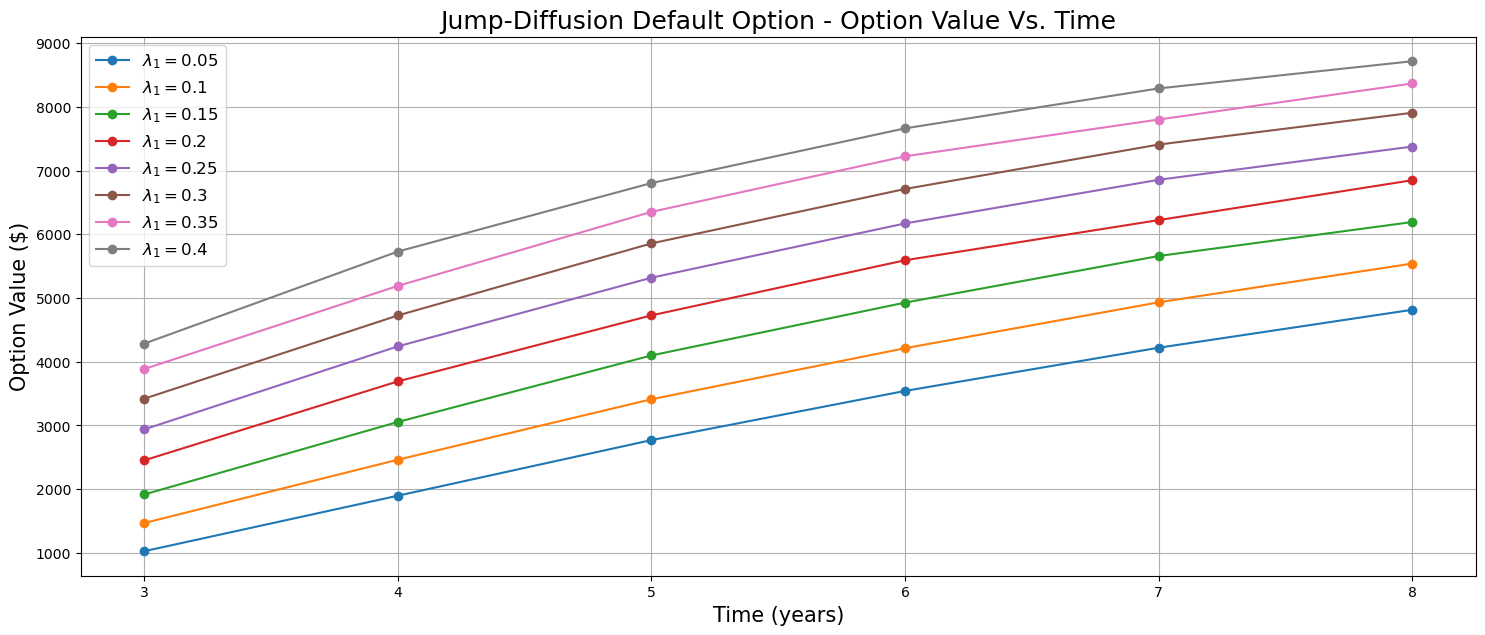

In [9]:
# Plot Option Value Vs. T
plt.figure(figsize=(18, 7))
for 𝜆1 in 𝜆1_vals:
    plt.plot(T_vals, df_q1_dov.loc[:, "𝜆1="+ str(𝜆1)].values, "-o", label="$\lambda_1=$"+ str(𝜆1))
plt.title("Jump-Diffusion Default Option - Option Value Vs. Time", fontsize=18)
plt.xlabel("Time (years)", fontsize=15)
plt.ylabel("Option Value ($)", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show();

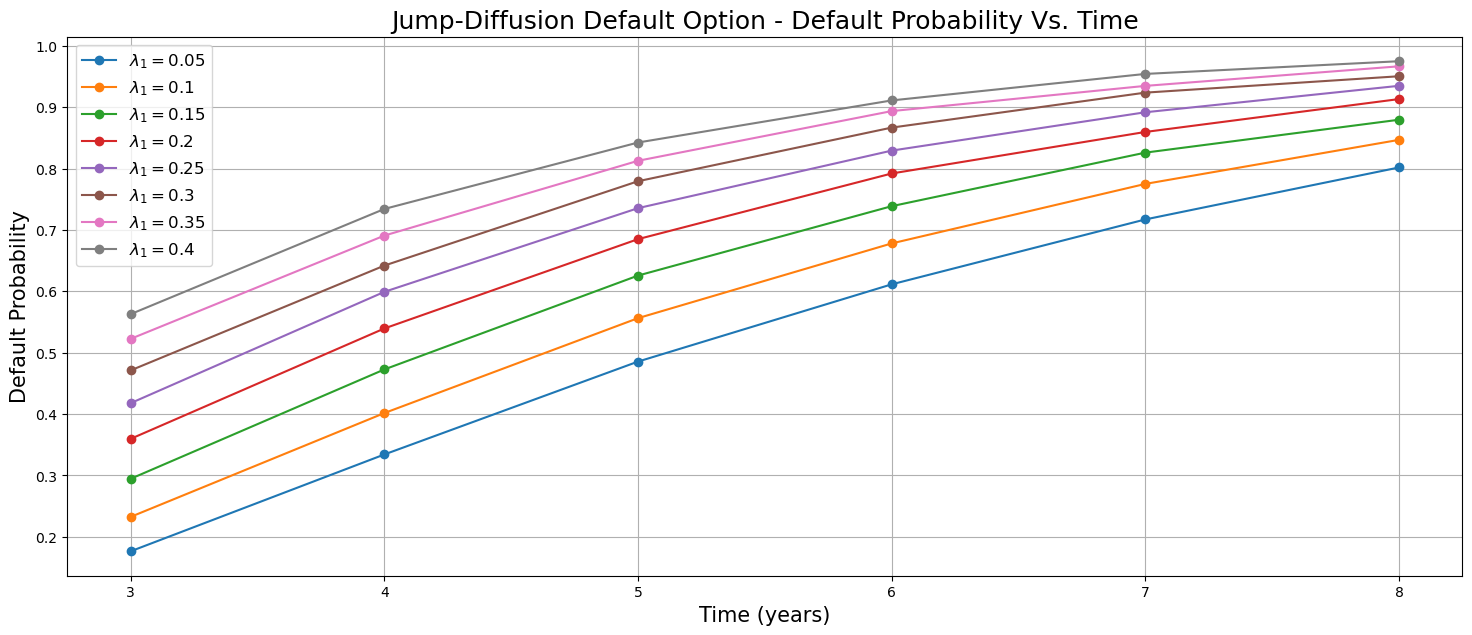

In [10]:
# Plot Default Probability Vs. T
plt.figure(figsize=(18, 7))
for 𝜆1 in 𝜆1_vals:
    plt.plot(T_vals, df_q1_def_prob.loc[:, "𝜆1="+ str(𝜆1)].values, "-o", label="$\lambda_1=$"+ str(𝜆1))
plt.title("Jump-Diffusion Default Option - Default Probability Vs. Time", fontsize=18)
plt.xlabel("Time (years)", fontsize=15)
plt.ylabel("Default Probability", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show();

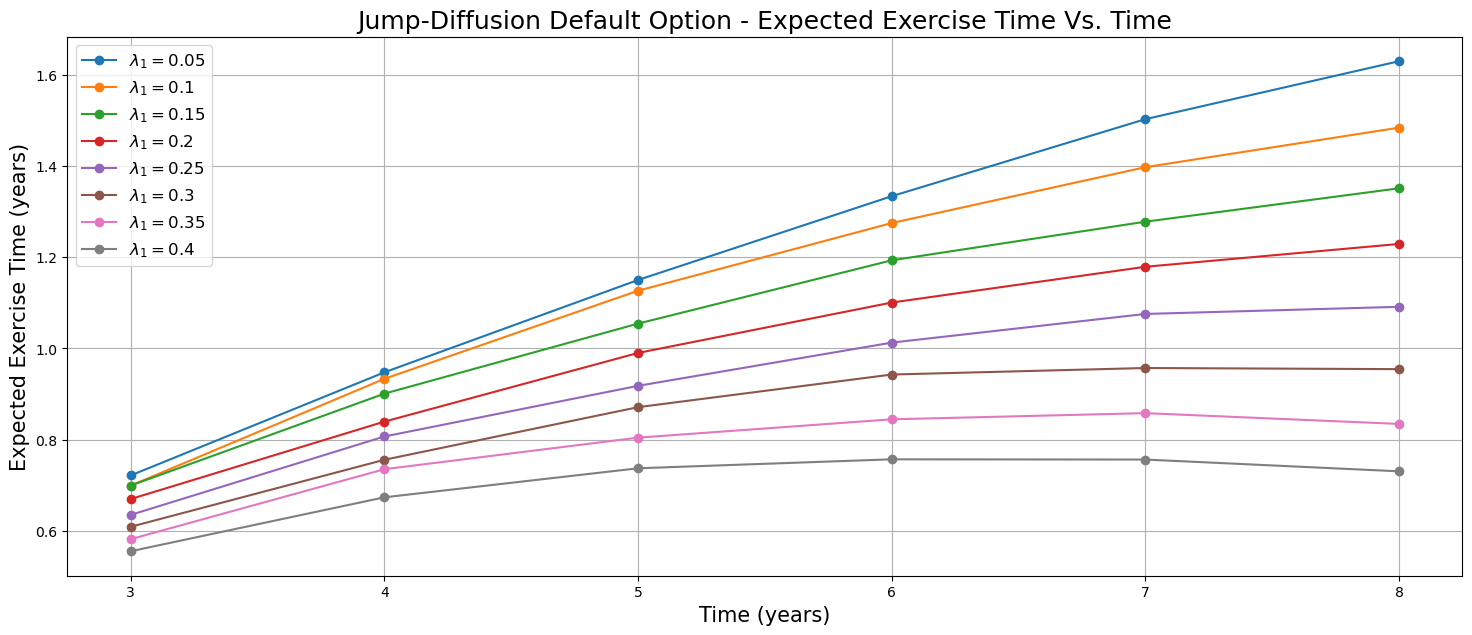

In [11]:
# Plot Expected Exercise Time Vs. T
plt.figure(figsize=(18, 7))
for 𝜆1 in 𝜆1_vals:
    plt.plot(T_vals, df_q1_avg_ex_time.loc[:, "𝜆1="+ str(𝜆1)].values, "-o", label="$\lambda_1=$"+ str(𝜆1))
plt.title("Jump-Diffusion Default Option - Expected Exercise Time Vs. Time", fontsize=18)
plt.xlabel("Time (years)", fontsize=15)
plt.ylabel("Expected Exercise Time (years)", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show();

## Question 2

In [12]:
# Computes barrier value for question 2.a
def barrier_a(T, t):
    return 94

# Computes barrier value for question 2.b
def barrier_b(T, t):
    return 6/T*t + 91

# Computes barrier value for question 2.c
def barrier_c(T, t):
    return -6/T*t + 97

In [13]:
# Estimates the price of a Down-and-Out European Put Otion using Monte Carlo simulation with Euler’s discretization
def DOEP_EDMC(S0, X, r, T, 𝛾, V0, 𝛼, 𝛽, 𝜌, dt, N, barrier, seed=42):
    np.random.seed(seed)
    ST = np.zeros(N)
    VT = np.zeros(N)

    # Multivariate Normal
    mvn_mean = [0, 0]
    mvn_cov = [[1, 𝜌], [𝜌, 1]]

    # Nubmer of time steps
    M = int(T/dt)

    # Compute N simulated terminal prices
    for i in range(N):
        # Create M multivariate stanrard normal samples
        z = np.random.multivariate_normal(mvn_mean, mvn_cov, size=M)

        # Initialize terminal stock and volatility with their t=0 values
        ST[i] = S0
        VT[i] = V0

        # Use Euler's discretization scheme with the full truncation method to time step
        for k in range(M):
            Vt_plus = max(0, VT[i])
            ST[i] = ST[i] + r*ST[i]*dt + np.sqrt(Vt_plus)*ST[i]*dt**0.5*z[k, 0]
            # If barrier is hit, no need to proceed on this path
            # Set terminal stock price to infinity to enusre that Put value evaluates to 0
            if ST[i] < barrier(T, (k+1)*dt):
                ST[i] = np.inf
                break
            VT[i] = VT[i] + (𝛼 + 𝛽*Vt_plus)*dt + 𝛾*np.sqrt(Vt_plus)*dt**0.5*z[k, 1]

       
    # Compute payoffs at expiry
    DOEP_T = (X-ST).clip(min=0)
    
    # Compute value of the option at t=0 using risk neutral measure
    DOEP_t = np.exp(-r*T)*DOEP_T

    # Return mean of all the simulated option values
    return DOEP_t.mean()

In [14]:
# Set parameters
seed = 42

S0 = 100
X = 100
r = 0.05
T = 1

V0 = 0.1
𝛼 = 0.45
𝛽 = -5.105
𝛾 = 0.25
𝜌 = -0.75

dt = 0.1
N = 100000

barriers = [barrier_a, barrier_b, barrier_c]
df_q2 = pd.DataFrame(index=["DOEP Price"], columns=["P1", "P2", "P3"])

In [15]:
# Compute prices
for i in range(len(df_q2.columns)):
    df_q2.loc["DOEP Price", df_q2.columns[i]] = DOEP_EDMC(S0, X, r, T, 𝛾, V0, 𝛼, 𝛽, 𝜌, dt, N, barriers[i], seed)

In [16]:
print("The price estimates for the three barriers:")
display(df_q2)

The price estimates for the three barriers:


,P1,P2,P3
DOEP Price,0.044032,0.011925,0.086479


With passage of time, the proportion of stock price paths going below a fixed value increases as variance is increasing with time. Due to this reason though the average barrier value is same in all the three cases, depending on how the barrier value is changing with time, the proportion of option values becoming 0 will vary.

As the barrier value is increasing with time in case (b), the proportion of stock path hitting the barrier in this case will be higher than the other two cases. Due to this reason, the proportion of options with 0 values be higher in case (b), which results in lower average option value.

Similarly, in case (c) where the barrier value is decreasing with time, the proportion of stock path hitting the barrier will be lower than the other two cases, hence average option value is highest in this case.

## Question 3

**Part a** 

In [2]:
# Given cash flows and respective time values computes the price of a bond using analytical solution for the CIR model
def Bond_CIR_Analytical(r0, 𝜎, 𝜅, r_bar, T, cf_vals, cf_times):
    # Compute CIR model h1, h2, and h3 values
    h1 = np.sqrt(𝜅**2 + 2*𝜎**2)
    h2 = (𝜅 + h1)/2
    h3 = 2*𝜅*r_bar/𝜎**2

    # Create an array to store present value of each cash flow
    P_0_t_r0 = np.zeros(len(cf_times))

    # Compute present value of each cash flow
    for i in range(len(cf_times)):
        t = cf_times[i]

        # Compute A(0, t)
        A_0_t = (h1*np.exp(h2*t)/(h2*(np.exp(h1*t)-1) + h1))**h3
        
        # Compute B(0, t)
        B_0_t = (np.exp(h1*t)-1)/(h2*(np.exp(h1*t)-1) + h1)
        
        # Compute P(0, t, r0)
        P_0_t_r0[i] = A_0_t*np.exp(-B_0_t*r0)*cf_vals[i]

    # Return the sum of present value of all the cash flows as the bond price
    return sum(P_0_t_r0)

In [3]:
# Generates interest rate paths using CIR model with Euler’s discretization scheme
def Gen_CIR_Paths(r0, 𝜎, 𝜅, r_bar, T, M=10000, N=16, seed=42):
    np.random.seed(seed)
    
    # Compute uniform time partition size
    Δ = T/N
        
    # Create array to store simulated interest rate values (including r0)
    rt = np.zeros((M, N+1))

    # Simulate M interest rate paths
    for i in range(M):
        # Initialize rt[0] with r0
        rt[i, 0] = r0

        # Generate std normal samples
        z = np.random.normal(0, 1, N+1)
        
        # For each time step
        for k in range(1, N+1):
            rt[i, k] = rt[i, k-1] + 𝜅*(r_bar - rt[i, k-1])*Δ + 𝜎*max(0, rt[i, k-1])**0.5*Δ**0.5*z[k]
    
    # Drop the first columns i.e. r0 values
    rt = rt[:, 1:]
    
    # Compute uniform time partition values, excluding t = 0
    t_vals = np.array([k*Δ for k in range(1, N+1)])
    
    # Return time values t = Δ, 2Δ, 3Δ, ..., NΔ and resepective inerest rate values
    return rt, t_vals

In [4]:
# Given interest rate paths/times and cash flows/times estimates the price of a bond
def Bond_EDMC(rt, t_vals, T, cf_vals, cf_times):
    # Compute dimensions
    M = rt.shape[0]
    N = rt.shape[1]

    # Compute uniform time partition size i.e. time-step size
    Δ = T/N
    
    # Compute number of time-steps between each coupon
    n_Δ = int(cf_times[0]/Δ)

    # Create array to store discounted cash flow values
    dcf = np.zeros((M, len(cf_times)))
    
    # For each simulated interest rate path
    for i in range(M):
        # For each cash flow time
        # There are n_Δ time-steps between each cash flow, so nth cash-flow corresponds to n_Δ*nth time in rt n = 1, 2, ...
        # e.g. if n_Δ = 4: 1st, 2nd, ... cash flow time correspond to 4th, 8th, ... rt vals
        for k in range(len(cf_times)):
            # Compute integral of r wrt time between 0 and cash flow time
            # There are n_Δ time-steps between each cash flow, so kth cash-flow corresponds to [n_Δ*(k+1)-1]th time in rt
            # e.g. if n_Δ = 4: 0th, 1st, 2nd, ... cash flow times correspond to 3rd, 7th, 11th, ... indices in rt array
            assert((cf_times[k] == t_vals[n_Δ*(k+1)-1]) == True)
            R = integrate.simps(rt[i, :n_Δ*(k+1)], t_vals[:n_Δ*(k+1)])
            
            # Compute discounted cash flow
            dcf[i, k] = np.exp(-R)*cf_vals[k]

    # Find mean of each cash flow across simulated samples then return their sum as the bond price
    return dcf.mean(axis=0).sum()

In [5]:
# Given cash flows and respective time values estimates the price of a bond using Monte Carlo simulation for the CIR model
def Bond_CIR_EDMC(r0, 𝜎, 𝜅, r_bar, T, cf_vals, cf_times, M=10000, N=16, seed=42):
    # Generate interest rate paths
    rt, t_vals = Gen_CIR_Paths(r0, 𝜎, 𝜅, r_bar, T, M=M, N=N, seed=seed)

    # Compute bond price
    P = Bond_EDMC(rt, t_vals, T, cf_vals, cf_times)
    
    return P

In [6]:
r0 = 5/100
𝜎 = 12/100
𝜅 = 0.92
r_bar = 5.5/100

In [7]:
T = 4
coupon = 30
fv = 1000
ann_freq = 2
n_periods = ann_freq*T

cf_vals = [30]*n_periods
cf_vals[-1] = cf_vals[-1] + 1000
cf_times = np.arange(0.5, 0.5*(n_periods+1), 0.5)

In [8]:
cpb_cir_edmc = Bond_CIR_EDMC(r0, 𝜎, 𝜅, r_bar, T, cf_vals, cf_times, M=10000, N=128, seed=42)
print("CIR Model - Coupon-paying bond price using Monte Carlo Simulation = {:.2f}".format(cpb_cir_edmc))

CIR Model - Coupon-paying bond price using Monte Carlo Simulation = 1023.60


In [9]:
cpb_cir_analytical = Bond_CIR_Analytical(r0, 𝜎, 𝜅, r_bar, T, cf_vals, cf_times)
print("CIR Model - Coupon-paying bond price using analytical method = {:.2f}".format(cpb_cir_analytical))

CIR Model - Coupon-paying bond price using analytical method = 1021.14


**Part b**

In [10]:
# Given face value and time computes the price of a pure discount bond using analytical solution for the CIR model
# Then uses analytical method for pricing the European Call Option on the bond
def EC_CIR_Analytical(r0, 𝜎, 𝜅, r_bar, T, K, S, fv):
    # Compute price of the  pure discount bond maturing at time T and S
    P_0_T_r0 = Bond_CIR_Analytical(r0, 𝜎, 𝜅, r_bar, T, np.array([1]), np.array([T]))
    P_0_S_r0 = Bond_CIR_Analytical(r0, 𝜎, 𝜅, r_bar, S, np.array([1]), np.array([S]))

    # Compute h1, h2 and h3 for the CIR Model
    h1 = np.sqrt(𝜅**2 + 2*𝜎**2)
    h2 = (𝜅 + h1)/2
    h3 = 2*𝜅*r_bar/𝜎**2
        
    # Compute A(T, S) and B(T, S) for the CIR Model
    A_T_S = (h1*np.exp(h2*(S-T))/(h2*(np.exp(h1*(S-T))-1) + h1))**h3
    B_T_S = (np.exp(h1*(S-T))-1)/(h2*(np.exp(h1*(S-T))-1) + h1)
    
    # Compute θ, ϕ, ψ and r_star for the CIR Model
    θ = np.sqrt(𝜅**2 + 2*𝜎**2)
    ϕ = 2*θ/(𝜎**2*(np.exp(θ*T)-1))
    ψ = (𝜅+θ)/𝜎**2
    # Divide K by fv as we need K wrt $1 face value
    r_star = np.log(A_T_S/(K/fv))/B_T_S

    # Calculate cdf values for the Non-Central 𝜒2 distribution
    x1 = 2*r_star*(𝜙 + 𝜓 + B_T_S)
    p = 4*𝜅*r_bar/𝜎**2
    q1 = 2*𝜙**2*r0*np.exp(θ*𝑇)/(𝜙 + 𝜓 + B_T_S)
    ncx2_1 = ncx2.cdf(x1, p, q1)

    x2 = 2*r_star*(𝜙 + 𝜓)
    q2 = 2*𝜙**2*r0*np.exp(θ*𝑇)/(𝜙 + 𝜓)
    ncx2_2 = ncx2.cdf(x2, p, q2)

    # Calculate option price
    C_0_T_S = fv*P_0_S_r0*ncx2_1 - K*P_0_T_r0*ncx2_2

    return C_0_T_S

In [11]:
# Computes the price of a pure discount bond using Monte Carlo simulation and analytical methods for the CIR model
# Then uses Monte Carlo simulation for pricing the European Call Option on the bond
def EC_CIR_EDMC(r0, 𝜎, 𝜅, r_bar, T, K, S, fv, M1=1000, M2=100, N=16, seed=42):
    # Generate CIR interest rate paths between [0, T]
    rt, t_vals = Gen_CIR_Paths(r0, 𝜎, 𝜅, r_bar, T, M=M1, N=N, seed=seed)
    
    # Extract rT values
    rT = rt[:, -1]
    
    # Create arrays to store simulated and analytical bond prices
    PDB_T_S_rT_MC = np.zeros(M1)
    PDB_T_S_rT_Anal = np.zeros(M1)
    
    # For each rT value, compute price of the pure discount bond at time t = T
    for i in range(M1):
        PDB_T_S_rT_MC[i] = Bond_CIR_EDMC(rT[i], 𝜎, 𝜅, r_bar, S-T, np.array([fv]), np.array([S-T]), M=M2, N=N, seed=seed)
        PDB_T_S_rT_Anal[i] = Bond_CIR_Analytical(rT[i], 𝜎, 𝜅, r_bar, S-T, np.array([fv]), np.array([S-T]))

    # Create arrays to store simulated option values using simulated and analytical bond prices
    C_0_T_S_MC = np.zeros(M1)
    C_0_T_S_Anal = np.zeros(M1)
    
    # For each rT value, compute payoff at time t = T then discount it to compute the option value
    for i in range(M1):
        payoff_mc = max(0, PDB_T_S_rT_MC[i] - K)
        C_0_T_S_MC[i] = np.exp(-(integrate.simps(rt[i, :], t_vals)))*payoff_mc
        
        payoff_anal = max(0, PDB_T_S_rT_Anal[i] - K)
        C_0_T_S_Anal[i] = np.exp(-(integrate.simps(rt[i, :], t_vals)))*payoff_anal

    # Return the mean of simulated option values as the option price
    return C_0_T_S_MC.mean(), C_0_T_S_Anal.mean()

In [19]:
r0 = 5/100
𝜎 = 12/100
𝜅 = 0.92
r_bar = 5.5/100

In [20]:
T = 0.5
K = 980
S = 1
fv = 1000

In [21]:
EC_CIR_MC, EC_CIR_MC_Anal = EC_CIR_EDMC(r0, 𝜎, 𝜅, r_bar, T, K, S, fv, M1=10000, M2=100, N=256, seed=42)

In [22]:
print("CIR Model - European Call Option price using Monte Carlo Simulation = {:.2f}".format(EC_CIR_MC))
print("CIR Model - European Call Option price using Monte Carlo Simulation (analytical bond price) = {:.2f}".format(EC_CIR_MC_Anal))

CIR Model - European Call Option price using Monte Carlo Simulation = 0.39
CIR Model - European Call Option price using Monte Carlo Simulation (analytical bond price) = 0.40


In [23]:
EC_CIR_Anal = EC_CIR_Analytical(r0, 𝜎, 𝜅, r_bar, T, K, S, fv)
print("CIR Model - European Call Option price using analytical method = {:.2f}".format(EC_CIR_Anal))

CIR Model - European Call Option price using analytical method = 0.39


**Part c**

In [24]:
def EC_CIR_IFD_r(r0, 𝜎, 𝜅, r_bar, T, X, S, fv, Δt, Δr):
    # Number of time splits
    M = int(T/Δt)
    # Number of price splits
    N = int(5*r0/Δr)
    
    # Compute Interest and Bond Price Values
    r = np.zeros(N+1)
    P = np.zeros(N+1)
    for j in range(N+1):
        r[j] = (N-j)*Δr
        P[j] = Bond_CIR_Analytical(r[j], 𝜎, 𝜅, r_bar, S-T, np.array([fv]), np.array([S-T]))
    
    # Compute Pu, Pm and Pd, Note that value at index 0 is redundant and never used
    pu = np.zeros(N)
    pm = np.zeros(N)
    pd = np.zeros(N)
    for j in range(1, N):
        pu[j] = 0.5*Δt*(-𝜎**2*j/Δr - 𝜅*r_bar/Δr + 𝜅*j/2)
        pm[j] = Δt*(1/Δt + 𝜎**2*j/Δr + r[-j-1])
        pd[j] = 0.5*Δt*(-𝜎**2*j/Δr + 𝜅*r_bar/Δr - 𝜅*j/2)
    
    # Create Matirx A    
    A = np.diag(list(pm[:0:-1])) + \
        np.diag(list(pu[-2:0:-1]), -1) + \
        np.diag(list(pd[:1:-1]), 1)
    
    # Array to store C matrix
    C = np.zeros(N-1)
    
    # Array to store B matrix
    B = np.zeros(N-1)
    
    # Initialize C with the excercise values at leaves
    for j in range(N-1):
        C[j] = max(0, P[j+1] - X)
    
    C = C.reshape((-1, 1))
    B = B.reshape((-1, 1))
    
    # Starting with (M-1)th level, iterate each level of the tree until 0th level
    for i in range(M-1, -1, -1):
        C = np.matmul(np.linalg.inv(A), (C - B))
            
    return C.mean()

In [25]:
r0 = 5/100
𝜎 = 12/100
𝜅 = 0.92
r_bar = 5.5/100

In [26]:
T = 0.5
X = 980
S = 1
fv = 1000

Δt = 0.001
Δr = 0.0005

EC_CIR_IFD = EC_CIR_IFD_r(r0, 𝜎, 𝜅, r_bar, T, X, S, fv, Δt, Δr)

In [27]:
print("CIR Model - European Call Option price using Implicit Finite-Difference method = {:.2f}".format(EC_CIR_IFD))

CIR Model - European Call Option price using Implicit Finite-Difference method = 0.36


The European Call Option prices computed using Monte Carlo Simulation (1.41) and Implicit Finite-Difference method (1.51) are clsoe to each other. The analytical value (1.44) is in-between these two values. Monte Carlo and Implicit Finite-Difference values can be improved further by increasing the number of simulation paths and number of grid points respectively.

## Question 4

In [36]:
# Given cash flows and respective time values computes the price of a bond using analytical solution for the G2++ model
def Bond_G2PP_Analytical(x0, y0, a, b, 𝜎, 𝜂, r0, ϕ0, ϕt, 𝜌, T, cf_vals, cf_times):
    # Create an array to store present value of each cash flow
    P_0_t_r0 = np.zeros(len(cf_times))

    # Compute present value of each cash flow
    for i in range(len(cf_times)):
        t = cf_times[i]
        
        # Compute V(0, t) for the G2++ model
        V_0_t_term1 = 𝜎**2/a**2*(t + 2/a*np.exp(-a*t) - 1/(2*a)*np.exp(-2*𝑎*t) - 3/(2*𝑎))
        V_0_t_term2 = 𝜂**2/b**2*(t + 2/b*np.exp(-b*t) - 1/(2*b)*np.exp(-2*b*t) - 3/(2*b))
        V_0_t_term3 = 2*𝜌*(𝜎*𝜂)/(a*b)*(t + 1/a*(np.exp(-𝑎*t) - 1) + 1/b*(np.exp(-b*t) - 1) - 1/(a+b)*(np.exp(-(a+b)*t)-1))
        V_0_t = V_0_t_term1 + V_0_t_term2 + V_0_t_term3

        # Compute R(0, t)
        R_0_t = ϕt*t + 1/a*(1 - np.exp(-a*t))*x0 + 1/b*(1 - np.exp(-b*t))*y0 - 1/2*V_0_t
        
        # Compute P(0, t, r0)
        P_0_t_r0[i] = np.exp(-R_0_t)*cf_vals[i]

    # Return the sum of present value of all the cash flows as the bond price
    return sum(P_0_t_r0)

In [37]:
# Given face value and time computes the price of a pure discount bond using analytical solution for the G2++ model
# Then uses analytical method for pricing the European Put Option on the bond
def EP_G2PP_Analytical(x0, y0, a, b, 𝜎, 𝜂, r0, ϕ0, ϕt, 𝜌, T, K, S, fv):
    # Compute price of the  pure discount bond maturing at time T and S
    P_0_T_r0 = Bond_G2PP_Analytical(x0, y0, a, b, 𝜎, 𝜂, r0, ϕ0, ϕt, 𝜌, T, np.array([1]), np.array([T]))
    P_0_S_r0 = Bond_G2PP_Analytical(x0, y0, a, b, 𝜎, 𝜂, r0, ϕ0, ϕt, 𝜌, S, np.array([1]), np.array([S]))

    # Compute Σ for the G2++ model
    Σ2_term1 = 1/2*𝜎**2/a**3*(1 - np.exp(-𝑎*(S-T)))**2*(1 - np.exp(-2*𝑎*T))
    Σ2_term2 = 1/2*𝜂**2/b**3*(1 - np.exp(-b*(S-T)))**2*(1 - np.exp(-2*b*T))
    Σ2_term3 = 2*𝜌*(𝜎*𝜂)/(a*b*(a+b))*(1 - np.exp(-𝑎*(S-T)))*(1 - np.exp(-b*(S-T)))*(1 - np.exp(-(𝑎+b)*T))
    Σ = np.sqrt(Σ2_term1 + Σ2_term2 + Σ2_term3)

    # Calculate cdf values for standard normal distribution
    x1 = np.log((K*P_0_T_r0)/(fv*P_0_S_r0))/Σ - Σ/2
    N1 = norm.cdf(x1)

    x2 = np.log((K*P_0_T_r0)/(fv*P_0_S_r0))/Σ + Σ/2
    N2 = norm.cdf(x2)

    # Calculate option price
    P_0_T_S = -fv*P_0_S_r0*N1 + K*P_0_T_r0*N2

    return P_0_T_S

In [38]:
# Generates interest rate paths using G2++ model with Euler’s discretization scheme
def Gen_G2PP_Paths(x0, y0, a, b, 𝜎, 𝜂, r0, ϕ0, ϕt, 𝜌, T, M=10000, N=16, seed=42):
    np.random.seed(seed)
    
    # Compute uniform time partition size
    Δ = T/N
        
    # Create array to store simulated xt, yt and interest rate values (including x0, y0 and r0)
    xt = np.zeros((M, N+1))
    yt = np.zeros((M, N+1))
    rt = np.zeros((M, N+1))
                   
    # Set multivariate normal parameters
    mvn_mean = [0, 0]
    mvn_cov = [[1, 𝜌], [𝜌, 1]]

    # Simulate M interest rate paths
    for i in range(M):
        # Initialize xt[0], yt[0] and rt[0] with x0, y0 and r0 respectively
        xt[i, 0] = x0
        yt[i, 0] = y0
        rt[i, 0] = r0

        # Create multivariate stanrard normal samples
        z = np.random.multivariate_normal(mvn_mean, mvn_cov, size=N+1)

        # For each time step
        for k in range(1, N+1):
            xt[i, k] = xt[i, k-1] - a*xt[i, k-1]*Δ + 𝜎*Δ**0.5*z[k, 0]
            yt[i, k] = yt[i, k-1] - b*yt[i, k-1]*Δ + 𝜂*Δ**0.5*z[k, 1]
            rt[i, k] = xt[i, k] + yt[i, k] + ϕt

    # Drop the first columns i.e. r0 values
    rt = rt[:, 1:]
    
    # Compute uniform time partition values, excluding t = 0
    t_vals = np.array([k*Δ for k in range(1, N+1)])
    
    # Return time values t = Δ, 2Δ, 3Δ, ..., NΔ and resepective inerest rate values
    return rt, t_vals

In [39]:
# Given cash flows and respective time values estimates the price of a bond using Monte Carlo simulation for the G2++ model
def Bond_G2PP_EDMC(x0, y0, a, b, 𝜎, 𝜂, r0, ϕ0, ϕt, 𝜌, T, cf_vals, cf_times, M=10000, N=16, seed=42):
    # Generate interest rate paths
    rt, t_vals = Gen_G2PP_Paths(x0, y0, a, b, 𝜎, 𝜂, r0, ϕ0, ϕt, 𝜌, T, M=M, N=N, seed=seed)

    # Compute bond price
    P = Bond_EDMC(rt, t_vals, T, cf_vals, cf_times)
    
    return P

In [40]:
# Computes the price of a pure discount bond using Monte Carlo simulation and analytical methods for the G2++ model
# Then uses Monte Carlo simulation for pricing the European Put Option on the bond
def EP_G2PP_EDMC(x0, y0, a, b, 𝜎, 𝜂, r0, ϕ0, ϕt, 𝜌, T, K, S, fv, M1=1000, M2=100, N=16, seed=42):
    # Generate G2++ interest rate paths between [0, T]
    rt, t_vals = Gen_G2PP_Paths(x0, y0, a, b, 𝜎, 𝜂, r0, ϕ0, ϕt, 𝜌, T, M=M1, N=N, seed=seed)
    
    # Extract rT values
    rT = rt[:, -1]
    
    # Create arrays to store simulated and analytical bond prices
    PDB_T_S_rT_MC = np.zeros(M1)
    PDB_T_S_rT_Anal = np.zeros(M1)
    
    # For each rT value, compute price of the pure discount bond at time t = T
    for i in range(M1):
        PDB_T_S_rT_MC[i] = Bond_G2PP_EDMC(x0, y0, a, b, 𝜎, 𝜂, rT[i], rT[i], rT[i], 𝜌,
                                          S-T, np.array([fv]), np.array([S-T]), M=M2, N=N, seed=seed)
        PDB_T_S_rT_Anal[i] = Bond_G2PP_Analytical(x0, y0, a, b, 𝜎, 𝜂, rT[i], rT[i], rT[i], 𝜌,
                                                  S-T, np.array([fv]), np.array([S-T]))

    # Create arrays to store simulated option values using simulated and analytical bond prices
    P_0_T_S_MC = np.zeros(M1)
    P_0_T_S_Anal = np.zeros(M1)
    
    # For each rT value, compute payoff at time t = T then discount it to compute the option value
    for i in range(M1):
        payoff_mc = max(0, K - PDB_T_S_rT_MC[i])
        P_0_T_S_MC[i] = np.exp(-(integrate.simps(rt[i, :], t_vals)))*payoff_mc
        
        payoff_anal = max(0, K - PDB_T_S_rT_Anal[i])
        P_0_T_S_Anal[i] = np.exp(-(integrate.simps(rt[i, :], t_vals)))*payoff_anal

    # Return the mean of simulated option values as the option price
    return P_0_T_S_MC.mean(), P_0_T_S_Anal.mean()

In [41]:
x0 = 0
y0 = 0
a = 0.1
b = 0.3
𝜎 = 5/100
𝜂 = 9/100
r0 = ϕ0 = 5.5/100
ϕt = 5.5/100
𝜌 = 0.7

In [42]:
T = 0.5
K = 950
S = 1
fv = 1000

In [43]:
EP_G2PP_MC, EP_G2PP_MC_Anal = EP_G2PP_EDMC(x0, y0, a, b, 𝜎, 𝜂, r0, ϕ0, ϕt, 𝜌, T, K, S, fv, M1=1000, M2=1000, N=256,seed=42)

In [44]:
print("G2PP Model - European Put Option price using Monte Carlo Simulation = {:.2f}".format(EP_G2PP_MC))
print("G2PP Model - European Put Option price using Monte Carlo Simulation (analytical bond price) = {:.2f}".format(EP_G2PP_MC_Anal))

G2PP Model - European Put Option price using Monte Carlo Simulation = 6.40
G2PP Model - European Put Option price using Monte Carlo Simulation (analytical bond price) = 6.67


In [45]:
EP_G2PP_Anal = EP_G2PP_Analytical(x0, y0, a, b, 𝜎, 𝜂, r0, ϕ0, ϕt, 𝜌, T, K, S, fv)
print("G2PP Model - European Put Option price using analytical method = {:.2f}".format(EP_G2PP_Anal))

G2PP Model - European Put Option price using analytical method = 6.17


The European Put Option prices computed using Monte Carlo Simulation (6.40) and explicit formula (6.17) are clsoe to each other. Monte Carlo value can be improved further by increasing the number of simulation paths.

**European Put Option Price Comparison by varying 𝜌**

In [46]:
# Define the grid
𝜌_vals = [x/10 for x in range(-7, 8)]

# Create dataframe to store values
df_q4 = pd.DataFrame()

df_q4["𝜌"] = 𝜌_vals

In [47]:
# Compute values
for i in range(len(𝜌_vals)):
    EP_G2PP_Anal_i = EP_G2PP_Analytical(x0, y0, a, b, 𝜎, 𝜂, r0, ϕ0, ϕt, 𝜌_vals[i], T, K, S, fv)
    df_q4.loc[i, "Option_Price"] = EP_G2PP_Anal_i

In [48]:
display(df_q4)

,𝜌,Option_Price
0,-0.7,0.978884
1,-0.6,1.384281
2,-0.5,1.795006
3,-0.4,2.203601
4,-0.3,2.606295
5,-0.2,3.001216
6,-0.1,3.387506
7,0.0,3.764866
8,0.1,4.133312
9,0.2,4.493029


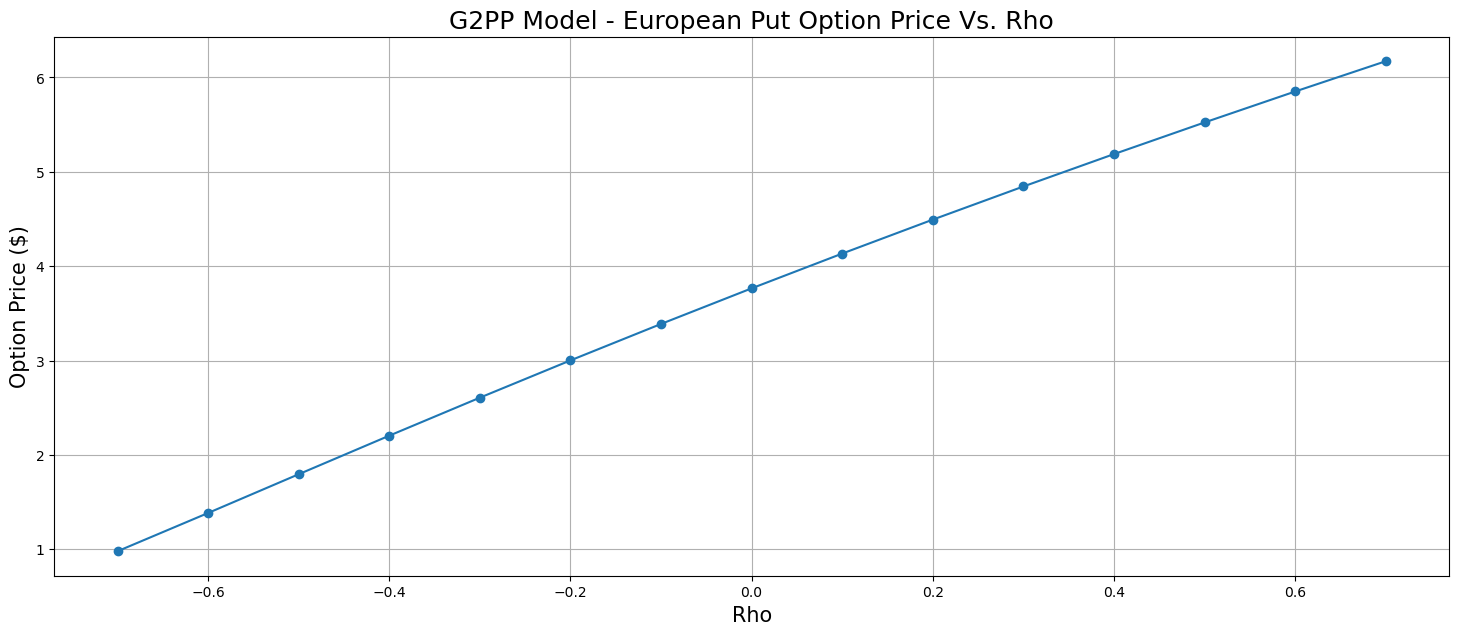

In [49]:
# Plot European Put Option Price Vs. 𝜌
plt.figure(figsize=(18, 7))
plt.plot(df_q4["𝜌"].values, df_q4["Option_Price"].values, "-o")
plt.title("G2PP Model - European Put Option Price Vs. Rho", fontsize=18)
plt.xlabel("Rho", fontsize=15)
plt.ylabel("Option Price ($)", fontsize=15)
plt.grid(True)
plt.show();

The European Put Option price is increasing with increasing $\rho$ value.

## Question 5

**Part a**

In [50]:
def numerix_CPR(r_MBS, PV_0, t, y_t_m_1_10, PV_t_m_1):
    SY = [0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98]
    RI_t = 0.28 + 0.14*np.a𝑟𝑐𝑡𝑎𝑛(-8.57 + 430*(12*r_MBS - y_t_m_1_10))
    BU_𝑡 = 0.3 + 0.7*PV_t_m_1/PV_0
    SG_t = min(1, t/30)
    SY_t = SY[t%12-1]
    CPR_t = RI_t * BU_t* SG_t * SY_t
    return CPR_t

In [51]:
# Given interest rate paths/times and MBS parameters estimates its price
def MBS_EDMC(r0, rt, t_vals, T, PV_0, cf_times, r_MBS):
    # Compute dimensions
    M = rt.shape[0]
    N = rt.shape[1]

    # Compute uniform time partition size i.e. time-step size
    Δ = T/N

    # Compute number of time-steps between each coupon
    n_Δ = int(cf_times[0]/Δ)

    # Create array to store discounted cash flow values for interest and principal payments
    dcf = np.zeros((M, len(cf_times)))

    # Create array to store discounted cash flow values for interest payments
    dcf_ip = np.zeros((M, len(cf_times)))

    # Create array to store discounted cash flow values for principal payments
    dcf_tpp = np.zeros((M, len(cf_times)))

    # For each simulated interest rate path
    for i in range(M):  
        
        # The outstanding mortgage balance at time (𝑡−1)
        PV_t_m_1 = PV_0
    
        # For each cash flow time
        # There are n_Δ time-steps between each cash flow, so nth cash-flow corresponds to n_Δ*nth time in rt n = 1, 2, ...
        # e.g. if n_Δ = 4: 1st, 2nd, ... cash flow time correspond to 4th, 8th, ... rt vals
        for k in range(len(cf_times)):
            # Compute integral of r wrt time between 0 and cash flow time
            # There are n_Δ time-steps between each cash flow, so kth cash-flow corresponds to [n_Δ*(k+1)-1]th time in rt
            # e.g. if n_Δ = 4: 0th, 1st, 2nd, ... cash flow times correspond to 3rd, 7th, 11th, ... indices in rt array
            assert((np.abs(cf_times[k] - t_vals[n_Δ*(k+1)-1]) <= 0.000001) == True)
            R = integrate.simps(rt[i, :n_Δ*(k+1)], t_vals[:n_Δ*(k+1)])

            # Compute Interest Payment
            IP = PV_t_m_1*r_MBS

            # Compute Scheduled Mortgage Payment
            MP = (PV_t_m_1*r_MBS)/(1 - 1/(1 + r_MBS)**(len(cf_times) - (k+1-1)))
            
            # Compute Scheduled Principal Payment
            SP = MP - IP

            # Compute 10-year US TSY Note Yield, observed of the end of 𝑡−1
            # If it is end of first time period use r0
            if k == 0:
                y_t_m_1_10 = -1/10*np.log(Bond_CIR_Analytical(r0, 𝜎, 𝜅, r_bar, 10, np.array([1]), np.array([10])))
            # Else use interest rate at the end of previous period
            else:
                y_t_m_1_10 = -1/10*np.log(Bond_CIR_Analytical(rt[i, n_Δ*k-1], 𝜎, 𝜅, r_bar, 10, np.array([1]), np.array([10])))

            # Cumpute CPR
            CPR = numerix_CPR(r_MBS, PV_0, k+1, y_t_m_1_10, PV_t_m_1)

            # Compute Prepayment
            PP = (PV_t_m_1 - SP)*(1 - (1 - CPR)**(1/12))

            # Compute Total Principal Payment, make sure that it is capped at remaining prinicpal balance
            TPP = min(PV_t_m_1, SP + PP)
                        
            # Compute total payment
            cf = IP + TPP

            # Compute discounted cash flow for interest and principal payments
            dcf[i, k] = np.exp(-R)*cf

            # Compute discounted cash flow for interest payment
            dcf_ip[i, k] = np.exp(-R)*IP

            # Compute discounted cash flow for principal payment
            dcf_tpp[i, k] = np.exp(-R)*TPP

            # Update outstanding mortgage balance
            PV_t_m_1 = PV_t_m_1 - TPP

            # Break if no more Principal Payment left
            if PV_t_m_1 <= 0:
                break

    # Find mean of each cash flow across simulated samples then return their sum as the MBS price
    return dcf, dcf.mean(axis=0).sum(), dcf_ip.mean(axis=0).sum(), dcf_tpp.mean(axis=0).sum()

In [52]:
# Estimates the price of a MBS using Monte Carlo simulation for the CIR model
def MBS_CIR_EDMC(r0, 𝜎, 𝜅, r_bar, T, PV_0, cf_times, r_MBS, M=10000, N=16, seed=42):
    # Generate interest rate paths
    rt, t_vals = Gen_CIR_Paths(r0, 𝜎, 𝜅, r_bar, T, M=M, N=N, seed=seed)

    # Compute MBS price
    dcf, P, P_IO, P_PO = MBS_EDMC(r0, rt, t_vals, T, PV_0, cf_times, r_MBS)
    
    return dcf, P, P_IO, P_PO

In [53]:
r0 = 0.078
𝜎 = 0.12
𝜅 = 0.6
r_bar = 0.08

In [54]:
T = 30
PV_0 = 100000
ann_freq = 12
n_periods = ann_freq*T
cf_times = np.arange(1/ann_freq, 1/ann_freq*(n_periods+1), 1/ann_freq)

In [55]:
WAC = 8/100
r_MBS = WAC/12

In [56]:
mbs_dcf, mbs_p, mbs_p_io, mbs_p_po = MBS_CIR_EDMC(r0, 𝜎, 𝜅, r_bar, T, PV_0, cf_times, r_MBS, M=10000, N=T*ann_freq*4, seed=42)

In [57]:
print("CIR Model - MBS price using Monte Carlo Simulation = {:.2f}".format(mbs_p))

CIR Model - MBS price using Monte Carlo Simulation = 100863.87


**Part b**

In [58]:
def OAS_solver(oas, cf_times, mbs_dcf, mkt_prc):
    # Compute mean of discounted cash flows at each time step
    mbs_dcf_means = mbs_dcf.mean(axis=0)

    # Add additional OAS discount factor at each time step
    mbs_dcf_means_oas = np.exp(-oas*cf_times)*mbs_dcf_means
    
    return mbs_dcf_means_oas.sum() - mkt_prc

def calc_OAS(cf_times, mbs_dcf, mkt_prc):
    OAS = optimize.newton(OAS_solver, 0, args=(cf_times, mbs_dcf, mkt_prc))
    return OAS

In [59]:
mkt_prc = 98000

In [60]:
mbs_oas = calc_OAS(cf_times, mbs_dcf, mkt_prc)

In [61]:
print("CIR Model - OAS Spread using Monte Carlo Simulation = {:.6f}".format(mbs_oas))

CIR Model - OAS Spread using Monte Carlo Simulation = 0.004321


**Part c**

In [62]:
print("CIR Model - MBS IO tranch price using Monte Carlo Simulation = {:.2f}".format(mbs_p_io))

CIR Model - MBS IO tranch price using Monte Carlo Simulation = 53690.16


In [63]:
print("CIR Model - MBS PO tranch price using Monte Carlo Simulation = {:.2f}".format(mbs_p_po))

CIR Model - MBS PO tranch price using Monte Carlo Simulation = 47173.71


**MBS Price Comparison by varying r_bar**

In [64]:
# Define the grid
r_bar_vals = [x/100 for x in range(4, 11)]

# Create dataframe to store values
df_q5 = pd.DataFrame()

df_q5["r_bar"] = r_bar_vals

In [65]:
# Compute values
for i in range(len(r_bar_vals)):
    mbs_dcf, mbs_p, mbs_p_io, mbs_p_po = MBS_CIR_EDMC(r0, 𝜎, 𝜅, r_bar_vals[i], T, PV_0, cf_times, r_MBS, M=1000, N=T*ann_freq*4, seed=42)
    df_q5.loc[i, "MBS_Price"] = mbs_p

In [66]:
display(df_q5)

,r_bar,MBS_Price
0,0.04,127380.913727
1,0.05,119779.300398
2,0.06,112892.699352
3,0.07,106668.192094
4,0.08,101044.619258
5,0.09,95959.978655
6,0.10,91355.263565


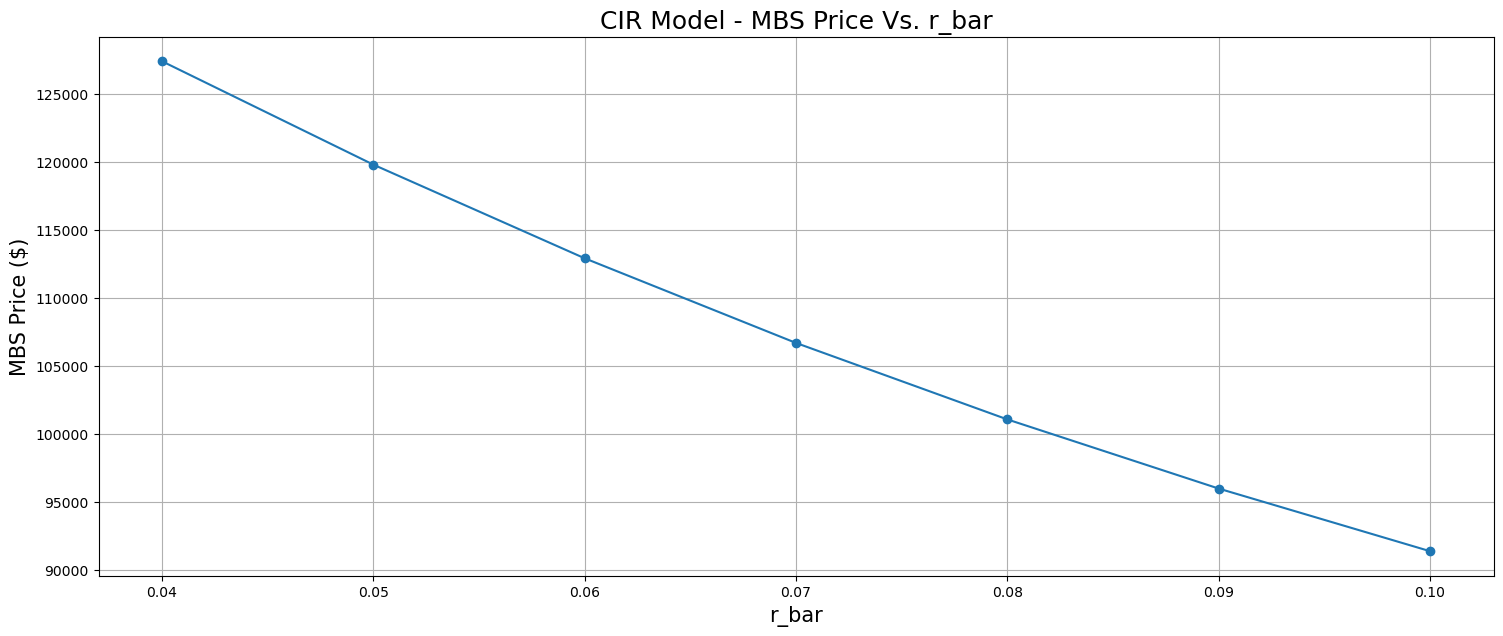

In [67]:
# Plot MBS Price Vs. r_bar
plt.figure(figsize=(18, 7))
plt.plot(df_q5["r_bar"].values, df_q5["MBS_Price"].values, "-o")
plt.title("CIR Model - MBS Price Vs. r_bar", fontsize=18)
plt.xlabel("r_bar", fontsize=15)
plt.ylabel("MBS Price ($)", fontsize=15)
plt.grid(True)
plt.show();

The MBS price is decreasing with increasing r_bar value.